# Data analysis with SciAnalysis

last updated: 2023 Apr 

In this notebook, we can load the raw tiff, load or extract metedata, analysis the data, save the analysis results and metadata in .H5.

--------------------------------------

*exp.dict*: The experiment dictionary. 'Experiment' is a series of measurements, e.g. in-situ thermal annealing measurements of a sample.

*exp.dict.keys()*: ['analysis', 'corr', 'corrdata', 'data', 'detector', 'exp_protocol', 'expinfo', 'expname', 'folder', 'mdata_list', 'metadata']

*exp.dict['expinfo'].keys()*: ['clock', 'filename', 'filenumber', 'patterns', 'scan_id', 'series_measure', 'time', 'uid']


--------------------------------------

In [ ]:
exp.dict['analysis'].keys()

# &#9635; A. SciAnalysis for Experiment

At home insitute, download SciAnalysis at: https://github.com/CFN-softbio/SciAnalysis



In [2]:
#%matplotlib nbagg

# Imports
########################################
import sys, os, time, glob, imageio, datetime, pprint
import sqlite3
import pandas as pd
from silx.io.dictdump import dicttoh5, h5todict

SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)

from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols
from SciAnalysis.ExpAnalysis import Experiment
from SciAnalysis.ExpAnalysis import Tools

%pwd

'/nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2/waxs/analysis'

## 1. Raw data

In [3]:
### Specify directory, detector, and files of interest

if 1:
    EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2/' 
    exp = Experiment.experiment('PBG_run1', folder=EXPR_DIR, det='waxs', beamline='cms') ##Experiment name: rbitrary or related to the sample name
    exp.dict['expinfo']['fn_patterns'] = ['*_PBG*run1*x0.0*y0.0*10133*']  #*10133

if 0:
    EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/RHeadrick3/' 
    exp = Experiment.experiment('B6_N3', folder=EXPR_DIR, det='waxs', beamline='cms') ##Experiment name: rbitrary or related to the sample name
    exp.dict['expinfo']['fn_patterns'] = ['*B6_N3_Trans3_map_vac_x*']  


### Load files
try:
    for pattern in exp.dict['expinfo']['fn_patterns']:
        #exp.defFiles_query(fn='PBG', folder=EXPR_DIR, scanid = [900000, 1200000], verbose=1) 
        exp.defFiles(fn=pattern, verbose=1) 
        #exp.defFiles(fn=pattern, scanid = [750000, 900000], verbose=1)  
    
    infiles = exp.dict['rawinfo']['filename']
    Nfiles = len(infiles)
    
except:
    print('\n!!! Databroker not working, loading files directly.')
    #exp.dict['expinfo']['beamline'] = None
    for pattern in exp.dict['expinfo']['fn_patterns']:
        exp.defFiles(fn=pattern, verbose=1)      
    

### Show some info   
exp.show()
exp.showFileInfo(idx=1)



At beamline, can use databroker
/nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2/waxs/raw/
Loaded 29 files.
(defFiles time = 0.7s)

=== Overview of experiment dictionary ===
exp.dict['expinfo']
    keys = ['expname', 'det', 'beamline', 'folder', 'fn_patterns']
    -    key = expname, val = PBG_run1
    -    key = det, val = waxs
    -    key = beamline, val = cms
    -    key = folder, val = /nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2/
    -    key = fn_patterns, val = ['*_PBG*run1*x0.0*y0.0*10133*']
exp.dict['rawinfo']
    keys = ['filename', 'time', 'clock', 'scan_id', 'uid', 'filenumber', 'series_measure']
    -    key = filename, len(shape) = 29
    -    key = time, len(shape) = 29
    -    key = clock, len(shape) = 29
    -    key = scan_id, len(shape) = 29
    -    key = uid, len(shape) = 29
    -    key = filenumber, val = 29
    -    key = series_measure, val = False
exp.dict['analysis']
exp.dict['corr']
    key = corr, val = []
exp.dict['corrdata']
exp.d

## 2. Metadata

In [4]:
### Check metadata at the beamline, identify md of interest, e.g. sample_temperature_D, sample_x

# import databroker
# cat = databroker.catalog[exp.beamline]
# h = cat[scan_id]
# h.metadata['start']

file_idx = 0
scan_id = exp.dict['rawinfo']['scan_id'][file_idx]
exp.showMetadata(scanid=scan_id, md_interest=None)
exp.showMetadata(scanid=scan_id, md_interest = ['sample_clock', 'sample_temperature_D'])
#exp.showMetadata(scanid=scan_id, md_interest = ['sample_clock', 'sample_x', 'sample_y'])

### Scan 1013368:
{'beam_int_bim3': 0.0,
 'beam_int_bim4': 0.0,
 'beam_int_bim5': 0.0,
 'beam_intensity_expected': 20000,
 'beam_size_x_mm': 0.1999979999999999,
 'beam_size_y_mm': 0.20000474999999973,
 'beamline_mode': 'measurement',
 'calibration_energy_keV': 13.5,
 'calibration_wavelength_A': 0.9184,
 'detectors': ['pilatus800'],
 'experiment_SAF_number': '310648',
 'experiment_alias_directory': '/nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2',
 'experiment_cycle': '2023_1',
 'experiment_group': 'beamline',
 'experiment_project': 'polymer',
 'experiment_proposal_number': '310000',
 'experiment_type': 'TSWAXS',
 'experiment_user': 'various',
 'filename': 'SA_PBG_air_insitu_capL_run1_1_0.0s_Linkam40.0C_x0.000_y0.000_5.00s_1013368',
 'hints': {'dimensions': [[['time'], 'primary']]},
 'measure_type': 'measure',
 'motor_SAXSx': -64.9936,
 'motor_SAXSy': -73.00000558,
 'motor_WAXSx': -220.0,
 'motor_WAXSy': 36.0,
 'motor_WAXSz': -0.0835,
 'motor_smx': -17.1,
 'motor_smy': 8.4,
 

In [5]:
# Options: (1) load metadata from databroker at beamline. (2) load md from h5. (3) Extract info from filename
md_load_option = 1


if md_load_option==1: # Load md from databroker, this only works at beamline
    exp.dict['mdata_list'] = ['sample_clock', 'sample_temperature_D'] # Specify metedata to load
    exp.loadMetadata()
    print(exp.dict['metadata'].keys())
    
elif md_load_option==2: # Load md from h5 (previously saved from databroker)
    h5_path = EXPR_DIR+"/data/"
    h5_file = 'B6_N3_metadata.h5'
    exp.dict['metadata'] = h5todict(h5_path+h5_file)


elif md_load_option==3: ## If databroker md is not available nor saved
    infiles = exp.dict['rawinfo']['filename']
    print('Number of files: {}'.format(len(infiles)))

    Ts = []
    sample_x = []
    sample_y = []
    scan_id = []
    for ii, infile in enumerate(infiles):
        temp = infile.split('_')
        if ii==0: print(temp)
        Ts.append(float(infile.split('Linkam')[1].split('C')[0]))
        sample_x.append(float(temp[-4][1:]))
        sample_y.append(float(temp[-3][1:]))
        scan_id.append(int(temp[-1]))

    exp.dict['metadata']['sample_temperature_D'] = Ts
    exp.dict['metadata']['sample_x'] = np.array(sample_x)
    exp.dict['metadata']['sample_y'] = np.array(sample_y)
    print(exp.dict['metadata'].keys())

else:
    print('No metadata loaded to the exp. dictionary!')

[0%] 
(loadMetadata time = 0.4s)
dict_keys(['sample_clock', 'sample_temperature_D'])


In [ ]:
### Save metadata (for offline analysis later on)
if 0:
    h5_path = EXPR_DIR+"/data/"
    h5_file = exp.name+'_metadata.h5'
    dicttoh5(exp.dict['metadata'], h5_path+h5_file)
    print(h5_path+h5_file)


## 3. Analysis

We suspect that loading analysis results is slow, faster if processing raw data. However, going through the protocals is also slow; storing it to the exp.dict also takes a bit time.

In [6]:
### Specify beamline config (e.g. beam energy, center, det-sample distance)
if 1: 
    #calibration = Calibration(wavelength_A=0.7293) # 17 keV
    calibration = Calibration(wavelength_A=0.9184) #13.5 keV
    calibration.set_image_size(981, height=1043) # Pilatus1M
    calibration.set_pixel_size(pixel_size_um=172.0)
    calibration.set_beam_position(313.5, 1043-314) #SA, 2023 Apr

    calibration.set_distance(0.259)
    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    mask = Mask(mask_dir+'Dectris/Pilatus800k_gaps-mask.png')
    #mask.load(mask_dir+'NSLSII_11BM_CMS/Pilatus800k_CMS_badpixels-mask.png ')
    
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'rot180' : False,
             #'flip' : True, # PSCCD
             }
run_args = { 'verbosity' : 3,
            #'save_results' : ['xml', 'plots', 'txt', 'hdf5'],
            }
process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)
#infiles = exp.dict['expinfo']['filename']


### Run analysis 
protocols = ['circular_average'] #['linecut_angle'] #['circular_average'] #, 'sector_average', 'linecut_qz']

exp.dict['analysis']['cali'] = [calibration.wavelength_A, calibration.x0, calibration.y0, calibration.distance_m]
#exp.dict['analysis'] = {} 
#for protocol in protocols:
#    exp.dict['analysis'][protocol] = {}

t0 = time.time()  
    
line_y_stack = []
for protocol in protocols:
    if 'circular_average' in protocol:
        for ii, infile in enumerate(infiles):
            if np.mod(ii+1, 100)==0: print('[{:.0f}%]'.format(ii/Nfiles*100))

            det = exp.dict['expinfo']['det']
            folder = exp.dict['expinfo']['folder']

            infile_fullpath = folder+'/'+det+'/raw/'+exp.dict['rawinfo']['filename'][ii]+'_'+det+'.tiff'
            data = process.load(infile_fullpath, calibration=calibration, mask=mask, run_args=run_args)

            ### Specify and run the protocols
            line_output = data.circular_average_q_bin(error=False)
            line_y_stack.append(line_output.y)

            if 0:
                exp.dict['analysis'][protocol][str(ii)] = {}
                exp.dict['analysis'][protocol][str(ii)]['q'] = line_output.x
                exp.dict['analysis'][protocol][str(ii)]['I(q)'] = line_output.y
        
        ### Save analysis to exp.dict
        if 1:
            exp.dict['analysis'][protocol] = {}
            exp.dict['analysis'][protocol]['q'] = line_output.x
            exp.dict['analysis'][protocol]['I_stack'] = line_y_stack   


            #x = Protocols.thumbnails(name=None) 
            #x.run(data, output_dir)
            
    #elif 'sector_average' in protocol: 
    #    line_output = data.sector_average_q_bin(angle=60, dangle=5)

    #elif 'linecut_qz' in protocol:
    #    line_output = data.linecut_qz(qr=0, dq=0.05)

    #elif 'linecut_angle' in protocol:
    #line_output = data.linecut_angle(q0=2.24, dq=0.01)
            
        
print('Done! (Analysis took {:.0f}s)\n'.format(time.time()-t0))

now = datetime.datetime.now()
dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
print("{}\n".format(dt_string))

print(exp.dict['analysis'].keys())

Done! (Analysis took 1s)

2023/04/25 17:22:31

dict_keys(['cali', 'circular_average'])


In [7]:
exp.show()


=== Overview of experiment dictionary ===
exp.dict['expinfo']
    keys = ['expname', 'det', 'beamline', 'folder', 'fn_patterns']
    -    key = expname, val = PBG_run1
    -    key = det, val = waxs
    -    key = beamline, val = cms
    -    key = folder, val = /nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2/
    -    key = fn_patterns, val = ['*_PBG*run1*x0.0*y0.0*10133*']
exp.dict['rawinfo']
    keys = ['filename', 'time', 'clock', 'scan_id', 'uid', 'filenumber', 'series_measure']
    -    key = filename, len(shape) = 29
    -    key = time, len(shape) = 29
    -    key = clock, len(shape) = 29
    -    key = scan_id, len(shape) = 29
    -    key = uid, len(shape) = 29
    -    key = filenumber, val = 29
    -    key = series_measure, val = False
exp.dict['analysis']
    keys = ['cali', 'circular_average']
    -    key = cali, val = [0.9184, 313.5, 729, 0.259]
    -    keys = ['q', 'I_stack']
    -    -    key = q, val.shape = (751,)
    -    -    key = I_stack, len(shape

__Instead of doing analysis, can load previously analyzed data__

In [468]:
if 0:
    exp.loadSciAnalysisData(keys=['circular_average'], analysis_folder=str(exp.dict['folder'])+'waxs/analysis/PBG_run1/', verbose=1)
    exp.dict['analysis'].keys()

analysis_folder = /nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2/waxs/analysis/PBG_run1/
[0%] 
[43%] 
[85%] 
loadSciAnalysisData time = 16.5s


dict_keys(['circular_average'])

## 4. Save 

Save experiment dictionary (exp.dict) to h5.

In [8]:
h5_path = EXPR_DIR+"/data/"
h5_file = str(exp.dict['expinfo']['expname']) + '_cms_exp.h5'
output_file = h5_path+h5_file


## Check if file exist, will not overwrite
if False:
    file_exist = os.path.isfile(output_file)
    count = 1
    while file_exist:
        print('{} exists, using a new filename'.format(output_file))
        h5_file = str(exp.dict['expname']) + '_exp_' + str(count) + '.h5'
        output_file = h5_path+h5_file
        file_exist = os.path.isfile(output_file)
        count = count + 1

        
## Save
dicttoh5(exp.dict, output_file)
print('Experiment saved as {}'.format(output_file))



Experiment saved as /nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2//data/PBG_run1_cms_exp.h5


### __Load__

Load experiment dictionary and recover the object 'exp', allowing for subsequent data visualization/analysis.

In [9]:
#%matplotlib nbagg
# Imports
########################################
import sys, os, time, glob, imageio, datetime, pprint
import sqlite3
import pandas as pd
from silx.io.dictdump import dicttoh5, h5todict
SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)
from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols
from SciAnalysis.ExpAnalysis import Experiment
from SciAnalysis.ExpAnalysis import Tools


### Load experiment dict (previuosly analyzed data)
if True:
    
    #exp_dict_h5 = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/RHeadrick3//data/B6_N3_cms_exp.h5'
    exp_dict_h5 = '/nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2//data/PBG_run1_cms_exp.h5'
    exp_dict_load = h5todict(exp_dict_h5)
    #print(exp_dict_load.keys())
    
    exp = Experiment.experiment(exp_dict_load['expinfo']['expname'], folder=exp_dict_load['expinfo']['folder'], det=exp_dict_load['expinfo']['det'], beamline=exp_dict_load['expinfo']['beamline']) 
    exp.dict = exp_dict_load
    
    print(exp.dict.keys())
    print('\nExperiment loaded!')

At beamline, can use databroker
dict_keys(['analysis', 'corr', 'corrdata', 'exp_protocol', 'expinfo', 'mdata_list', 'metadata', 'rawinfo'])

Experiment loaded!


### __Overview of exp__

In [10]:
exp.show()


=== Overview of experiment dictionary ===
exp.dict['analysis']
    keys = ['cali', 'circular_average']
    -    key = cali, val = [9.184e-01 3.135e+02 7.290e+02 2.590e-01]
    -    keys = ['I_stack', 'q']
    -    -    key = I_stack, val.shape = (29, 751)
    -    -    key = q, val.shape = (751,)
exp.dict['corr']
    key = corr, val = []
exp.dict['corrdata']
exp.dict['exp_protocol']
    key = exp_protocol, val = []
exp.dict['expinfo']
    keys = ['beamline', 'det', 'expname', 'fn_patterns', 'folder']
    -    key = beamline, val = cms
    -    key = det, val = waxs
    -    key = expname, val = PBG_run1
    -    key = fn_patterns, val = ['*_PBG*run1*x0.0*y0.0*10133*']
    -    key = folder, val = /nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2/
exp.dict['mdata_list']
    key = mdata_list, val = ['sample_clock' 'sample_temperature_D']
exp.dict['metadata']
    keys = ['sample_clock', 'sample_temperature_D']
    -    key = sample_clock, val.shape = (29,)
    -    key = sample_t

## 5. Plot

### Option 1. 

#### &#9642; __Plot curves__

##### - __Load one curve & find peaks__

In [13]:
### Show one curve and find peaks

#protocol = 'circular_average'
protocol = list(exp.dict['analysis'].keys())[0]
print(protocol)

## Pick a curve
file_idx = 0
line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][file_idx])  


%matplotlib inline
#%matplotlib ipympl
plt.figure(1, figsize=(12,5)); plt.clf()
q_peaks = Tools.plot_peaks(line_plot, N_peaks_find = 25, fit_param=[0, 1, 0.001], flag_log=1, line_color='k', label_color='r', verbose=1)  #Tools.rand_color(0.5, 0.8)


cali


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

__Plot curves for the entire experiment__

In [11]:
%matplotlib inline
plt.figure(1, figsize=(12,10)); plt.clf()
Nfiles = len(exp.dict['rawinfo']['filename'])
infile = exp.dict['rawinfo']['filename'][0]

qrange_plot = [0.5, 3.9] ###
q_label = q_peaks #[1.278, 1.88, 2.219, 2.564, 2.905]; # Label the lines

cmap = mpl.colormaps['jet'] #viridis, jet, hsv, brg
colors = cmap(np.linspace(0.0, 1.0, Nfiles))
flag_log = 1

sample_temperature_D = exp.dict['metadata']['sample_temperature_D']
#sample_x = exp.dict['metadata']['sample_x']



### Plot
x_axis = exp.dict['analysis'][protocol]['q'] 
idx_min = int(np.argmin(np.abs(x_axis-qrange_plot[0])))
idx_max = int(np.argmin(np.abs(x_axis-qrange_plot[1])))

I_stack = exp.dict['analysis'][protocol]['I_stack']
spacing_plot = 0.7 #arbitrary

if flag_log:
    I_stack = np.log(I_stack)
    
    
for ii in np.arange(Nfiles):
    if sample_temperature_D[ii]>349.8:
        color = 'r'
        linestyle = None #'dashed' #dotted, dashed
    else:
        color = colors[ii]*0.8
        linestyle = None
        
    plt.plot(x_axis[idx_min:idx_max],I_stack[ii][idx_min:idx_max]+ii*spacing_plot, linestyle=linestyle, color=color, label=sample_temperature_D[ii])
    #plt.grid('minor')

for q in q_label:
    plt.plot([q, q], [min(I_stack[0])*0.8, max(I_stack[0])*1.2+Nfiles*spacing_plot], 'k',  alpha=0.2)

    
plt.legend(fontsize=7, ncols=7, bbox_to_anchor=(1.01, 1.01)) 
plt.title('{}, N={}'.format(infile.split('raw')[-1], Nfiles))



NameError: name 'q_peaks' is not defined

<Figure size 1200x1000 with 0 Axes>

##### - __Plot curves together as 2D image__

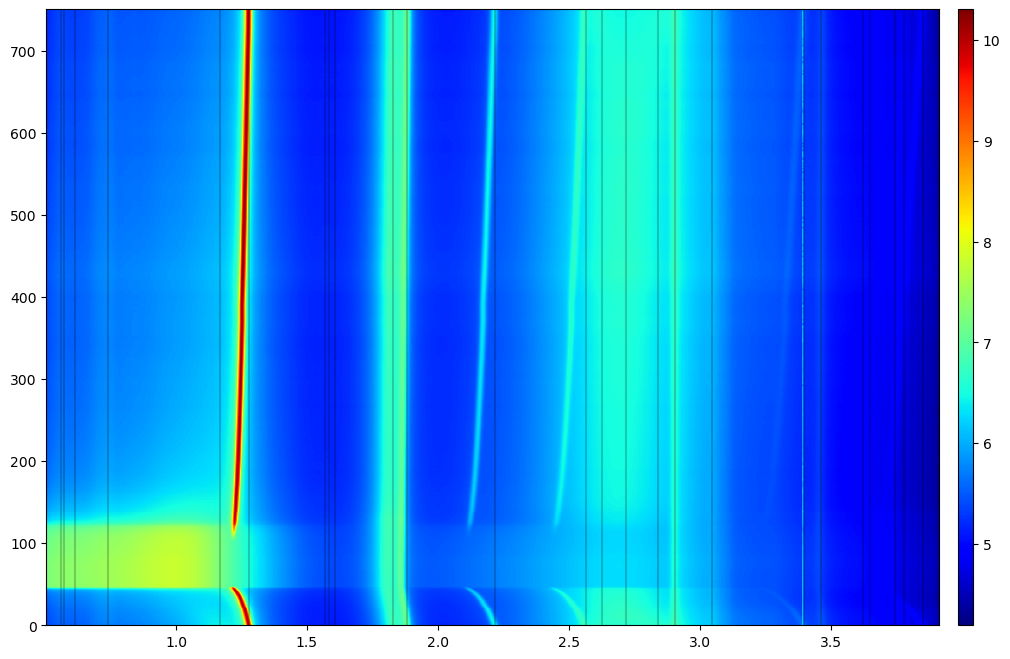

In [25]:
q_label = q_peaks #[1.278, 1.88, 2.219, 2.564, 2.905]; # Label the lines
flag_log = True

protocol = 'circular_average'
#protocol = list(exp.dict['analysis'].keys())[0]



x_axis = exp.dict['analysis'][protocol]['q'] 
I_stack = exp.dict['analysis'][protocol]['I_stack']
if flag_log:
    I_stack = np.log(I_stack)
    
%matplotlib inline
plt.figure(2, figsize=(12,8)); plt.clf()
plt.imshow(I_stack, origin='lower', cmap='jet', extent = [np.min(x_axis), np.max(x_axis), 0, I_stack.shape[1]],  aspect='auto') #aspect='auto' 0.005
cbar = plt.colorbar(fraction=0.02, pad=0.02, aspect=40) 
     
for q in q_label:
    plt.plot([q, q], [0, I_stack.shape[1]], 'k',  alpha=0.2)
    

#### &#9642; __Extract 0D feature & Plot 1D__

##### - __Load one curve for peak fitting__

{'fit_peaks_b': {'error': 0.1897357468935732, 'value': 6.164260510102417},
 'fit_peaks_chi_squared': 0.0008624562686950458,
 'fit_peaks_d0': {'error': 0.00017468069721519552, 'value': 0.3421956441193911},
 'fit_peaks_d01': {'error': 0.00017468069721519552,
                   'value': 0.3421956441193911},
 'fit_peaks_d02': {'error': 4.653090859628003e-05,
                   'value': 0.33367769542009673},
 'fit_peaks_grain_size': {'error': 0.1161465381041572,
                          'value': 5.386531143192898},
 'fit_peaks_grain_size1': {'error': 0.1161465381041572,
                           'value': 5.386531143192898},
 'fit_peaks_grain_size2': {'error': 0.7710304233579518,
                           'value': 21.981805941198488},
 'fit_peaks_m': {'error': 0.11081904310994439, 'value': -0.4913080097567027},
 'fit_peaks_prefactor1': {'error': 0.02227376497375211,
                          'value': 1.5155068985167113},
 'fit_peaks_prefactor2': {'error': 0.028363966058288233,
           

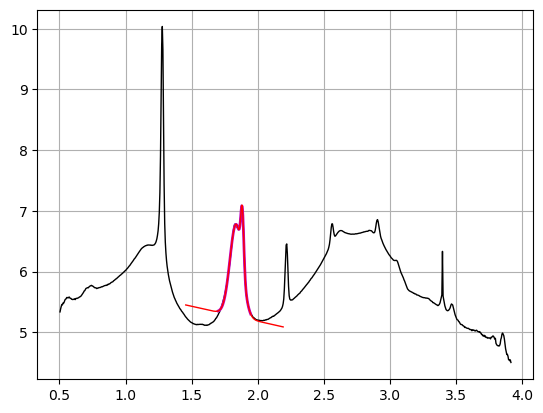

In [27]:
### Show one curve & do fitting
protocol = 'circular_average'

file_idx = 0
line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][file_idx])  

q0 = [1.82, 1.86]
fit_range = [1.7, 1.95]
flag_log = True


if flag_log == 1:
    line_plot.y = np.log(line_plot.y)

## Fitting
run_args = { 'verbosity' : 3,
             #'fittype': 'voigt',
            }
results = {}
protocol = Protocols.fit_peaks()
lines = protocol._fit(line_plot, results, **run_args, q0=q0, num_curves=len(q0), fit_range=fit_range)



pprint.pprint(lines.results)
for nn, line in enumerate(lines.lines):
        
    if nn==0: 
        plt.plot(line.x, line.y, 'k', linewidth=1, label=line.name)
        plt.title(line.name)
    elif nn==1:
        plt.plot(line.x, line.y, 'm', linewidth=2, label=line.name)
    else:
        plt.plot(line.x, line.y, 'r', linewidth=1, label=line.name)
        
    plt.grid()

__Apply fitting for the experiment__

In [29]:
protocol = 'circular_average'
q0 = [1.82, 1.86]
fit_range = [1.7, 1.95]


## Fitting
run_args = { 'verbosity' : 3,
             #'fittype': 'voigt',
            }
p = Protocols.fit_peaks()
    

## Fitting all curves
peak_x1 = []
peak_x2 = []
peak_pre1 = []
t0 = time.time()
for ii in np.arange(Nfiles):
    line_plot = DataLine(x = exp.dict['analysis'][protocol]['q'], y = exp.dict['analysis'][protocol]['I_stack'][ii])  
    
    lines = p._fit(line_plot, results={}, **run_args, q0=q0, num_curves=2, fit_range=fit_range)

    peak_x1.append(lines.results['fit_peaks_x_center1']['value'])
    peak_x2.append(lines.results['fit_peaks_x_center2']['value'])
    peak_pre1.append(lines.results['fit_peaks_prefactor1']['value'])

print('Fitting took {:.0f}s\n'.format(time.time()-t0))

#Ts = exp.dict['metadata']['sample_temperature_D']
#scan_ids = exp.dict['rawinfo']['scan_id']


Fitting took 4s



In [34]:
exp.dict['analysis']['circular_average']['fit_peaks_x_center1'] = peak_x1
exp.dict['analysis']['circular_average']['fit_peaks_x_center2'] = peak_x2
exp.show()


=== Overview of experiment dictionary ===
exp.dict['analysis']
    keys = ['circular_average']
    -    keys = ['I_stack', 'q', 'fit_peaks_x_center1', 'fit_peaks_x_center2']
    -    -    key = I_stack, val.shape = (469, 751)
    -    -    key = q, val.shape = (751,)
    -    -    key = fit_peaks_x_center1, len(shape) = 469
    -    -    key = fit_peaks_x_center2, len(shape) = 469
exp.dict['corr']
    key = corr, val = []
exp.dict['corrdata']
exp.dict['exp_protocol']
    key = exp_protocol, val = []
exp.dict['expinfo']
    keys = ['beamline', 'det', 'expname', 'fn_patterns', 'folder']
    -    key = beamline, val = cms
    -    key = det, val = waxs
    -    key = expname, val = PBG_run1
    -    key = fn_patterns, val = ['*_PBG*run1*x0.0*y0.0*']
    -    key = folder, val = /nsls2/data/cms/legacy/xf11bm/data/2023_1/beamline/ETsai2/
exp.dict['mdata_list']
    key = mdata_list, val = ['sample_clock' 'sample_temperature_D']
exp.dict['metadata']
    keys = ['sample_clock', 'sample_temper

In [30]:
#Convert list or dict to dataframe:
df_list = pd.DataFrame(peak_x1, columns=['peak_x1'])


__Alternatively, other feature extration (e.g. q with max intensity)__

In [ ]:
### Get the q with max intensity within this range

protocol = 'circular_average'
y = []
for ii in np.arange(Nfiles):
    line_plot = DataLine(x = exp.dict['data'][protocol][str(ii)]['q'], y = exp.dict['data'][protocol][str(ii)]['I(q)'])  
    line_x = line_plot.x
    line_y = line_plot.y
    y.append(line_y[idx_min:idx_max])
    
qrange_plot = [1, 1.5] 


Ts = exp.dict['metadata']['sample_temperature_D']
scan_ids = exp.dict['expinfo']['scan_id']

idx_min = int(np.argmin(np.abs(x_axis-qrange_plot[0])))
idx_max = int(np.argmin(np.abs(x_axis-qrange_plot[1])))

x_axis = line_x
q_peakmax_list = []
data_show = []
for ii in np.arange(len(y)):
    line_y = y[ii]
    line_y_crop = line_y[idx_min:idx_max]
    line_x_crop = x_axis[idx_min:idx_max]
    q_peakmax = line_x_crop[np.argmax(line_y_crop)]
    q_peakmax_list.append(q_peakmax)
    data_show.append([Ts[ii], scan_ids[ii], q_peakmax])

df_line_s = pd.DataFrame(q_peakmax_list, columns=['I'])
df_show = pd.DataFrame(data_show, columns = ['RH', 'scan_id', 'q_peakmax'])

print(q_peakmax_list[0:5])

##### - __Compare three 1D curves__

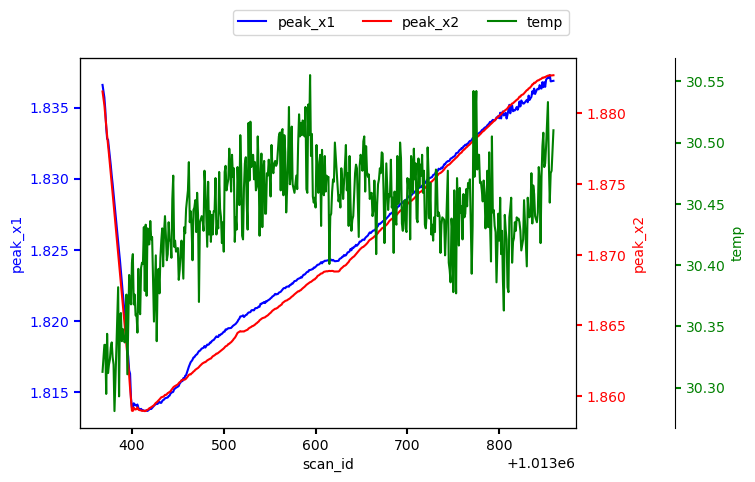

In [31]:
Ts = exp.dict['metadata']['sample_temperature_D']
scan_ids = exp.dict['rawinfo']['scan_id']

if 1:
    labels = ["peak_x1", "peak_x2", "temp"]
    p1, = ax.plot(scan_ids, peak_x1, "b-", label=labels[0])
    p2, = twin1.plot(scan_ids, peak_x2, "r-", label=labels[1])
    p3, = twin2.plot(scan_ids, Ts, "g-", label=labels[2])
else:
    p1, = ax.plot(scan_ids, q_peakmax_list, "b-", label="q")
    p2, = twin1.plot(scan_ids, np.array(Ts), "r-", label="Temperature")
    #p3, = twin2.plot([0, 1, 2], [50, 30, 15], "g-", label="Humidity")
    

fig, ax = plt.subplots()
#fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()
twin2 = ax.twinx()
twin2.spines.right.set_position(("axes", 1.2))

#ax.set_xlim(0, 2)
#ax.set_ylim(0, 2)
#twin1.set_ylim(0, 4)
#twin2.set_ylim(1, 65)

ax.set_xlabel("scan_id")
ax.set_ylabel(labels[0])
twin1.set_ylabel(labels[1])
twin2.set_ylabel(labels[2])

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

ax.legend(handles=[p1, p2, p3], ncols=3, bbox_to_anchor=(1, 1.15))
plt.show()

#### &#9642; __Extract 0d feature & Plot 2D map__

In [ ]:
### ROI
if 0:
    reduced_data = exp.dict['data']['roi']
    print('Len(reduced_data) = {}'.format(len(reduced_data)))
    print(reduced_data.keys())

    feature_list = []
    for ii in np.arange(0,len(reduced_data)):
        feature_list.append(reduced_data['stats_average'][ii])

In [481]:
### Angle

reduced_data = exp.dict['data']['linecut_angle']
print('Len(reduced_data) = {}'.format(len(reduced_data)))

x_pos = exp.dict['metadata']['sample_x']
y_pos = exp.dict['metadata']['sample_y']


feature_list = []
for ii in np.arange(0,len(reduced_data)):
    angle = reduced_data[str(ii)]['q']
    I = reduced_data[str(ii)]['I(q)']
    chi = angle[np.argmax(I)]
    feature_list.append(chi)


Len(reduced_data) = 3450


##### - __Plot scalar 2D mage__

(-2.5, 2.4000500000000002, -1.8000500000000001, 1.6000500000000002)

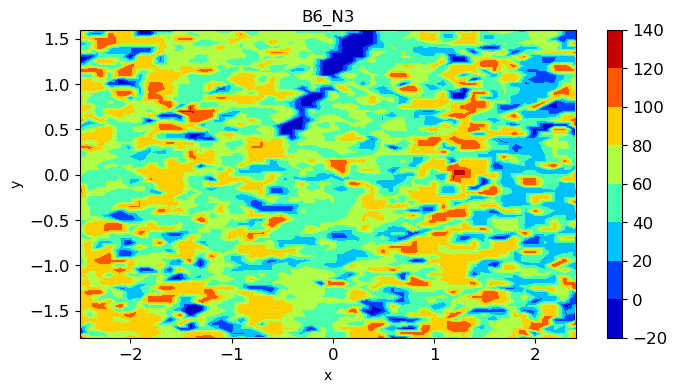

In [482]:
plt.figure(); plt.clf()

#plt.tripcolor(x_pos, y_pos, feature_list)  
plt.tricontourf(x_pos, y_pos, feature_list, cmap = 'jet') 

plt.colorbar()
plt.xlabel('x'); plt.ylabel('y')
plt.title(exp.dict['expname'])
plt.axis('equal')
plt.axis('tight')

#plt.plot(x_pos, y_pos, 'k.')

__Plot scalar image with interpolation__

(-2.5, 2.3999999999998956, -1.8000500000000001, 1.5999499999999274)

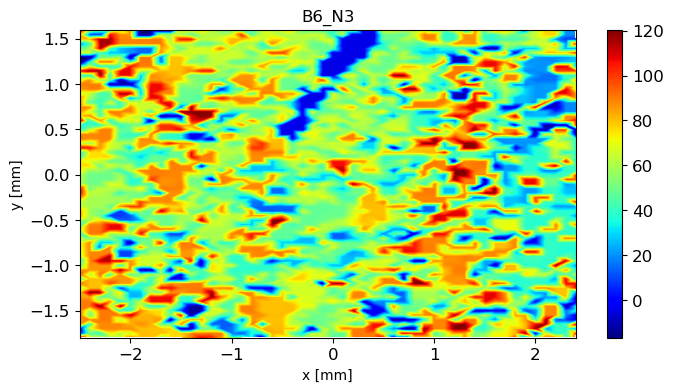

In [437]:
plot_interp = ['linear', 0.005] 
x_pos_fine, y_pos_fine, feature = Tools.interp_map(x_pos, y_pos, feature_list, plot_interp) 

plt.figure(); 
extent = (np.nanmin(x_pos_fine), np.nanmax(x_pos_fine), np.nanmin(y_pos_fine), np.nanmax(y_pos_fine))

plt.imshow(feature, extent=extent, origin='lower', cmap='jet') #, clim=[-180, 180])  
plt.colorbar()
plt.xlabel('x [mm]'); plt.ylabel('y [mm]')
plt.title(exp.dict['expname'])
plt.axis('equal')
plt.axis('tight')

##### - __Plot quiver__

In [438]:
u_list = []
v_list = []
chi_list = []
for chi in feature_list:
    u = np.cos(np.deg2rad(chi)) 
    v = np.sin(np.deg2rad(chi)) 
    u_list.append(u)
    v_list.append(v)
    chi_list.append(chi)

Text(0.5, 1.0, 'PBG_run1')

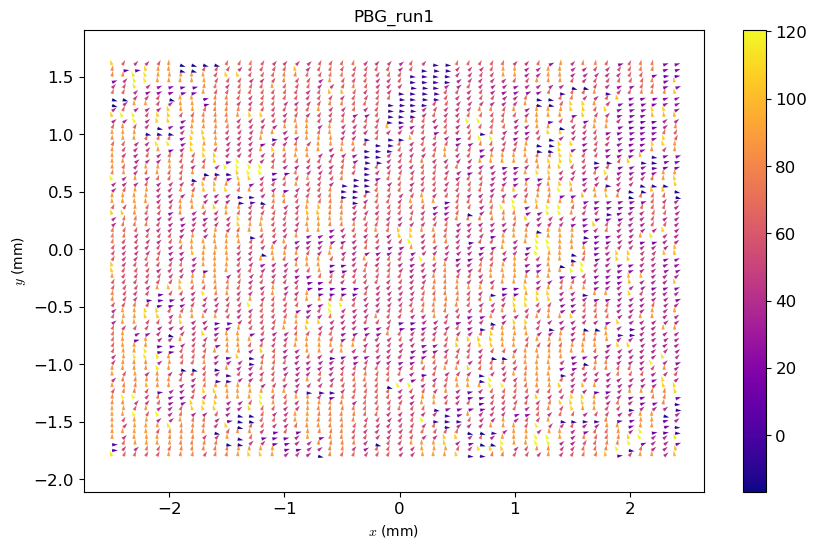

In [459]:
fig, ax = plt.subplots(figsize=[10, 6])

q = ax.quiver(x_pos, y_pos, u_list, v_list, chi_list, cmap = 'plasma') #,clim=[0,0.3])

#ax.set_xlim([-0.2,5])
#ax.set_ylim([-0.2,5])
ax.axis('equal')
ax.set_xlabel('$x$ (mm)'); ax.set_ylabel('$y$ (mm)')

cb = plt.colorbar(q)
plt.title(exp.dict['expname'])
# plt.savefig('SAXS mapping_quiver polt_colorbar.png', dpi = 600)


### Option 2. 

#### &#9642; Perform correlation 

In [461]:
print('Analysis data: {}\n'.format(exp.dict['data'].keys()))
exp.doCorr(corrs = [['2Darray']])

print(exp.dict['corrdata']['2Darray']['circular_average'].keys())
print(exp.dict['data']['circular_average'][str(0)].keys())

Analysis data: dict_keys(['circular_average'])

doCorr circular_average
dict_keys(['I(q)', 'I_array', 'file_index', 'scan_id', 'time', 'sample_clock', 'sample_temperature_D'])
dict_keys(['I(q)', 'q'])


#### &#9642; Plot data

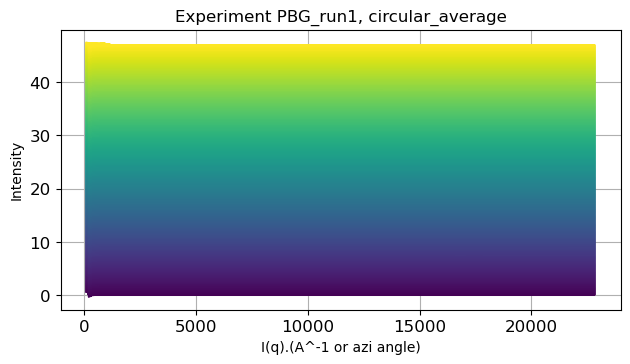

In [462]:
%matplotlib inline

exp.plotWaterfall(key = 'circular_average', y_spacing=0.1, flag_log=[0, 1])
#exp.plotWaterfall(key = 'sector_average', y_spacing=1)
#exp.plotWaterfall(key = 'linecut_qz', y_spacing=100)

/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/SciAnalysis/ExpAnalysis/Experiment.py:518: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x_axis[plot_xrange], y_idx, I_array[:,plot_xrange])


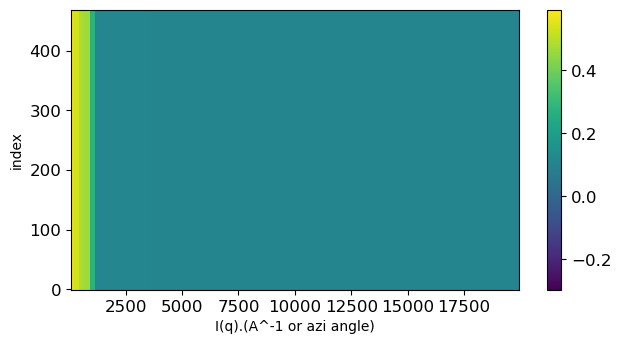

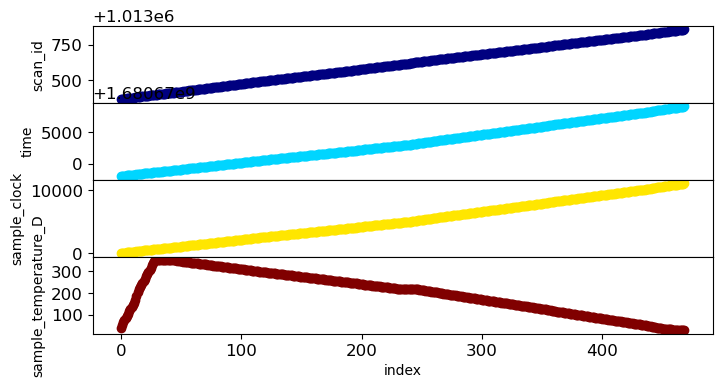

In [463]:
exp.plotHeatmap(key = protocol)

In [ ]:
EXPR_DIR = '/nsls2/data/cms/legacy/xf11bm/data/2022_2/LZhu5/PE_120C_fastscan_50V_30V_1mms_500pa_run1'

exp = Experiment.experiment('PE_120C_fastscan_50V_30V_1mms_500pa_run1', folder=EXPR_DIR, det='maxs', beamline='cms') #, beamline=None) ### CHANGE THIS, this expriment name can be arbitrary 
filenames = ['PE_120C_fastscan_50V_30V_1mms_500pa_run1_x-0.002_y0.001_0.10s'] ### Specify the sample

for filename in filenames:
    exp.defFiles_query(fn=filename, folder=EXPR_DIR, scanid = [600000, 900000], verbose=1) 
    
    
    
    

Specify calibration & Load filenames

In [ ]:
#%matplotlib nbagg
# Imports
########################################
import sys, os, time, glob, imageio, datetime

SciAnalysis_PATH='/nsls2/data/cms/legacy/xf11bm/software/SciAnalysis/' ### Specify this
#SciAnalysis_PATH = '/home/etsai/BNL/Users/software/SciAnalysis/'
SciAnalysis_PATH in sys.path or sys.path.append(SciAnalysis_PATH)

from SciAnalysis import tools
from SciAnalysis.XSAnalysis.Data import *
from SciAnalysis.XSAnalysis import Protocols

if 1: 
    calibration = Calibration(wavelength_A=0.7293) # 17 keV
    calibration.set_image_size(981, height=1043) # Pilatus1M
    calibration.set_pixel_size(pixel_size_um=172.0)
    calibration.set_beam_position(313.5, 1043-314) #SA, 2023 Apr

    calibration.set_distance(0.259)
    mask_dir = SciAnalysis_PATH + '/SciAnalysis/XSAnalysis/masks/'
    mask = Mask(mask_dir+'Dectris/Pilatus800k_gaps-mask.png')
    #mask.load(mask_dir+'NSLSII_11BM_CMS/Pilatus800k_CMS_badpixels-mask.png ')
       
###--------------------------------------------------------- 
source_dir = exp.folder+'/'+exp.det+'/raw/'

        
# for regular scan/snap measurements
if not exp.dict['expinfo']['series_measure']:
    filenames = exp.dict['expinfo']['filename']

# series measurements
else: 
    infile = exp.dict['expinfo']['filename'][0]

    # to remove extension
    if infile[:-5] == '.tiff':
        infile = infile[:-5]

    # to remove scanid in the filename for the data before 2023 (incorrect scanid) and add the exposure_period
    jan2023 = time.mktime(datetime.datetime.strptime('01/01/2023',"%m/%d/%Y").timetuple())
    if exp.dict['expinfo']['time'][0] < jan2023:
        infile = '_'.join(infile.split('_')[:-1]) 
        exposure_period = float(infile.split('_')[-1].split('s')[0])
        exp.dict['expinfo']['exposure_period'] = exposure_period
        scan_id = exp.dict['expinfo']['scan_id'][0]
        infile = '_'.join([infile,str(scan_id+1)])

    filenames = ['_'.join([infile,str(kk).zfill(6)]) for kk in range(Nfile)]
    
    

Specify analysis protocols and run analysis

In [ ]:
load_args = { 'calibration' : calibration, 
             'mask' : mask,
             #'rot180' : False,
             #'flip' : True, # PSCCD
             }
run_args = { 'verbosity' : 3,
            #'save_results' : ['xml', 'plots', 'txt', 'hdf5'],
            }

process = Protocols.ProcessorXS(load_args=load_args, run_args=run_args)


line_cir = []
line_sector = []

t0 = time.time()
for ii, infile in enumerate(filenames):
    if np.mod(ii, 200)==0:
        print('[{:0.0f}%]'.format(ii/Nfile*100))
    data = process.load(source_dir+infile+'_'+exp.det+'.tiff', calibration=calibration, mask=mask, run_args=run_args)

    line_cir = data.circular_average_q_bin(error=False, bins_relative=1.0)
    #line_sector.append(data.sector_average_q_bin(angle=60, dangle=5))

    
print('Done!')    
print('Done! Took {:.0f}s'.format(time.time()-t0))


### Put analysis results into the experiment dictionary (exp.dict) for downstream analysis/visualization
if 0:
    protocol = 'sector_average'
    exp.dict['data'][protocol] = {}
    for nn, line in enumerate(line_sector):
        exp.dict['data'][protocol][str(nn)] = {}
        exp.dict['data'][protocol][str(nn)]['q'] = line_sector[nn].x    
        exp.dict['data'][protocol][str(nn)]['I(q)'] = line_sector[nn].y
else:
    protocol = 'circular_average'
    exp.dict['data'][protocol] = {}
    for nn, line in enumerate(line_sector):
        exp.dict['data'][protocol][str(nn)] = {}
        exp.dict['data'][protocol][str(nn)]['q'] = line_cir[nn].x    
        exp.dict['data'][protocol][str(nn)]['I(q)'] = line_cir[nn].y

    